Let us start with the most basic question*: **what does it mean to analyze a signal?**
- Time domain analysis
- Frequency domain analysis

Signals are often not what we want them to be. For example,
- DC supply will have some harmonics of the input frequency,
- Devices are nonlinear,
- Modulated signal consists of a number of frequencies.

How do we measure signal impurity?


*actually the most basic question would be "what is a signal", but nvm.

# Introduction to Distortion
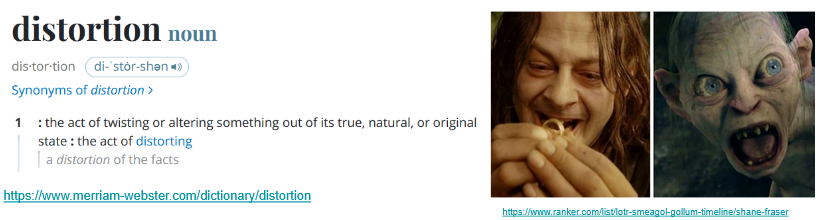


## What is Distortion?

Informally, a signal is said to be **distorted** if its shape changes as it passes through a system. In other words, the output waveform is not a scaled or phase-shifted version of the input (this, if you recall, by definition, is the difference between a linear and a non-linear system).

Common causes:
- Nonlinear elements (e.g., diodes, amplifiers near saturation)
- Clipping due to limited power supply
- Improper filtering

We will start by generating a pure sine wave and then applying distortion to it.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Sampling parameters
fs = 5000        # Sampling frequency in Hz
duration = 0.01  # 10 ms
f = 1000         # Fundamental frequency (1 kHz)

# Time vector and sine wave
t = np.linspace(0, duration, int(fs*duration))
x = np.sin(2*np.pi*f*t)

plt.figure()
plt.plot(t, x)
plt.title("Pure Sine Wave (1 kHz)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

## Adding Distortion

Let us apply different nonlinear operations to the sine wave to simulate distortion.

In [ ]:
# Hard clipping
y_clip = np.clip(x, -0.5, 0.5)

# Soft nonlinearity (squaring)
y_square = np.sign(x) * (x**2)

plt.figure(figsize=(10, 4))
plt.plot(t, x, label="Original")
plt.plot(t, y_clip, label="Hard-Clipped", linestyle='--')
plt.plot(t, y_square, label="Squared Nonlinearity", linestyle=':')
plt.legend()
plt.title("Types of Distortion in Time Domain")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

## Spectrum Analysis

Distortion creates **new frequency components** — usually at harmonics of the fundamental frequency.

We will use the Fast Fourier Transform (FFT) to view this.

In [ ]:
from scipy.fft import fft, fftfreq

def plot_spectrum(signal, fs, title):
    N = len(signal)
    freqs = fftfreq(N, 1/fs)
    X = np.abs(fft(signal))/N
    pos = freqs > 0

    plt.figure()
    plt.plot(freqs[pos], 20*np.log10(X[pos]))
    plt.title(title)
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Magnitude [dB]")
    plt.grid(True)
    plt.show()

plot_spectrum(x, fs, "Spectrum of Pure Sine Wave")
plot_spectrum(y_clip, fs, "Spectrum of Hard-Clipped Signal")

## Discussion

1. The **clipped signal** contains higher harmonics — multiples of 1 kHz.
2. The presence of these extra frequencies are what we call **harmonic distortion**.
3. Nonlinear devices (e.g., amplifiers near saturation) introduce similar effects.
4. Next, we will **quantify** this effect using the **Total Harmonic Distortion (THD)** in the following lesson.

---

### Some optional exercises
- Change the clipping level (e.g., `np.clip(x, -0.8, 0.8)`) and observe the spectrum.
- Add a `np.tanh()` nonlinearity and compare its harmonic content.
- Change the input frequency and see how the harmonics move.


## Context Matters: When is it Really Distortion?

The word **"distortion"** is context-dependent. Often, certain nonlinearities are *intentional*:
- A **limiter** prevents voltage or amplitude from exceeding safe levels.
- A **compressor** deliberately reshapes the dynamic range.
- A **guitar overdrive pedal** uses clipping to *create* a musical tone.

In these cases, the waveform *looks distorted*, but it is the **intended function** of the system. Hence, distortion is **not an absolute property** of the waveform itself,  but of the **system's intent and context**.



# Harmonic Distortion and THD

## What is Harmonic Distortion?

When a system introduces nonlinearities, the output waveform contains **harmonics**: frequencies that are **integer multiples** of the fundamental frequency. For a signal with fundamental frequency $f_1$, let $f_2 = 2f_1, f_3 = 3f_1, f_4 = 4f_1, \ldots$. These components define **2nd**, **3rd**, **4th**, etc. *order harmonic distortion*, respectively.

- **2nd-order distortion:** energy at $2f_1$
- **3rd-order distortion:** energy at $3f_1$
- and so on...

Let us visualize this using a simple nonlinear system.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

fs = 50000
duration = 0.01
f1 = 1000
t = np.linspace(0, duration, int(fs*duration))

# Fundamental (1 kHz sine)
x = np.sin(2*np.pi*f1*t)

# Introduce harmonic distortion (simulate nonlinearity)
y = x + 0.3*(x**2) + 0.2*(x**3)

plt.figure(figsize=(10, 4))
plt.plot(t, y)
plt.title("Signal with Harmonic Distortion (Nonlinear Combination)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

In [ ]:
def plot_spectrum(signal, fs, title):
    N = len(signal)
    freqs = fftfreq(N, 1/fs)
    X = np.abs(fft(signal))/N
    pos = freqs > 0
    plt.figure()
    plt.stem(freqs[pos], X[pos])
    plt.title(title)
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Amplitude")
    plt.xlim(0, 10000)
    plt.grid(True)
    plt.show()

plot_spectrum(y, fs, "Spectrum Showing Harmonic Distortion")


### Observation
You should see strong peaks at:
- 1 kHz → Fundamental (1st harmonic)
- 2 kHz → 2nd harmonic (2nd order distortion)
- 3 kHz → 3rd harmonic (3rd order distortion)
and possibly higher multiples.

Each harmonic corresponds to a *specific order of distortion* introduced by the nonlinear system.


## Total Harmonic Distortion (THD)

THD measures the **amount of harmonic energy** relative to the fundamental. For RMS voltage (amplitude) components $V_1, V_2, V_3, \ldots $:

$THD = \frac{\sqrt{V_2^2 + V_3^2 + V_4^2 + \ldots}}{V_1}$


We can express THD in ratio or percentage form.


In [ ]:
# Compute FFT
N = len(y)
Y = np.abs(fft(y))/N
freqs = fftfreq(N, 1/fs)

# Identify harmonic bins
pos = freqs > 0
freqs = freqs[pos]
Y = Y[pos]

# Find fundamental and first few harmonics
harmonics = [f1 * n for n in range(1, 6)]
indices = [np.argmin(np.abs(freqs - h)) for h in harmonics]

V = [Y[i] for i in indices]  # Amplitude of each harmonic

V1 = V[0]
Vh = np.sqrt(np.sum(np.square(V[1:])))
THDr = Vh / V1
THDf = THDr * 100

print(f"Fundamental (V1): {V1:.4f}")
for n, v in enumerate(V[1:], start=2):
    print(f"Harmonic {n}: {v:.4f}")
print(f"\nTotal Harmonic Distortion (THDr) = {THDr:.4f}")
print(f"Total Harmonic Distortion (THDf) = {THDf:.2f}%")


In [ ]:
orders = np.arange(1, len(V)+1)
plt.figure()
plt.bar(orders, V)
plt.xticks(orders)
plt.xlabel("Harmonic Order")
plt.ylabel("Amplitude")
plt.title("Harmonic Components in Distorted Signal")
plt.grid(True)
plt.show()


## Discussion

- Each harmonic represents an **order of distortion**.
- The **total harmonic distortion** quantifies the overall deviation from a pure sine wave.
- In amplifiers, **THD < 1%** is usually considered very good for audio applications.

## What is a Notch Filter?

A **notch filter** (also called a *band-stop* or *band-reject* filter) rejects a narrow band of frequencies around a chosen center frequency $\omega_0$. A standard **second-order notch filter** has the transfer function:

$
H(s) = \frac{s^2 + \omega_0^2}{s^2 + \frac{\omega_0}{Q}s + \omega_0^2}
$

where:

- $\omega_0$ = center (notch) angular frequency, in radians per second  
- $Q$  = *quality factor*, which measures how narrow or wide the notch is

### Intuition about Q
- A **high Q** → narrow, sharp notch  
- A **low Q** → wide, shallow notch  

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

%matplotlib inline

# Define notch filter parameters
f0 = 1000       # notch frequency [Hz]
Q = 10          # quality factor
omega0 = 2 * np.pi * f0

# Continuous-time transfer function
num = [1, 0, omega0**2]
den = [1, omega0/Q, omega0**2]

H_notch = signal.TransferFunction(num, den)

# Frequency sweep
w = np.logspace(1, 5, 1000)  # 10 Hz to 100 kHz
w, mag, phase = signal.bode(H_notch, w)

# Bode plot
plt.figure(figsize=(9,6))

plt.subplot(2,1,1)
plt.semilogx(w/(2*np.pi), mag)
plt.title("Bode Plot of Notch Filter")
plt.ylabel("Magnitude [dB]")
plt.grid(True, which="both")

plt.subplot(2,1,2)
plt.semilogx(w/(2*np.pi), phase)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Phase [deg]")
plt.grid(True, which="both")

plt.tight_layout()
plt.show()


## Unity Feedback Loop

Now we place the notch filter inside a **unity feedback loop**. For a system with open-loop transfer function \( H(s) \) and unity feedback, the **closed-loop transfer function** is:


$T(s) = \frac{H(s)}{1 + H(s)}$

We will compute and visualize this \( T(s) \) for the same notch filter.

In [ ]:
# Closed-loop transfer function T(s) = H(s) / (1 + H(s))

# Combine numerator and denominator
num_T = num
den_T = np.polyadd(den, num)  # denominator = den + num

T_closed = signal.TransferFunction(num_T, den_T)

# Frequency response
w, mag_T, phase_T = signal.bode(T_closed, w)

# Plot
plt.figure(figsize=(9,6))

plt.subplot(2,1,1)
plt.semilogx(w/(2*np.pi), mag_T)
plt.title("Closed-Loop Bode Plot (Notch Filter in Unity Feedback)")
plt.ylabel("Magnitude [dB]")
plt.grid(True, which="both")

plt.subplot(2,1,2)
plt.semilogx(w/(2*np.pi), phase_T)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Phase [deg]")
plt.grid(True, which="both")

plt.tight_layout()
plt.show()


## Comparing Open-Loop and Closed-Loop Responses

Let us compare the magnitude response of the open-loop and closed-loop systems to understand how feedback modifies the notch.

In [ ]:
plt.figure(figsize=(8,4))
plt.semilogx(w/(2*np.pi), mag, label="Open-Loop |H(s)|")
plt.semilogx(w/(2*np.pi), mag_T, label="Closed-Loop |T(s)|", linestyle='--')
plt.title("Comparison of Open-Loop and Closed-Loop Magnitude Responses")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude [dB]")
plt.grid(True, which="both")
plt.legend()
plt.show()

## Observations

The **open-loop notch filter** strongly attenuates the center frequency $f_0$. In the **unity feedback loop**, the closed-loop transfer function becomes $T(s) = \frac{H(s)}{1 + H(s)}$. This tends to **flatten** the response near the notch frequency because feedback reduces the variation in the transfer magnitude. This principle is key in distortion analyzers like the HP333A: by using a tuned feedback loop, the system can **actively cancel** a specific frequency component (e.g. the fundamental) while letting others (harmonics, noise) pass to measurement circuits.


# The Wien Bridge and Its Frequency-Dependent Balance

The **Wien bridge** is a classic AC bridge circuit used for **measuring frequency**, **testing oscillators**, and **distortion analysis**. It consists of four arms arranged in a bridge network:

- One arm: a **series RC** combination  
- The opposite arm: a **parallel RC** combination  
- The remaining two arms: pure resistors (often equal)

When an AC signal of a particular frequency is applied, the bridge becomes **balanced** (output is zero). This frequency is determined by the **values of R and C**.


## 1. Wien Bridge Circuit and Balance Condition

Consider the bridge arms as follows:

| Arm | Components |
|-----|-------------|
| AB  | Series combination of $R_1$ and $C_1$ |
| BC  | Pure resistor $R_3$ |
| AD  | Parallel combination of $R_2$ and $C_2$ |
| DC  | Pure resistor $R_4$ |

The input voltage $V_{\text{in}}$ is applied between nodes A and C, and the output $V_{\text{out}}$ is measured between nodes B and D. At balance, the bridge satisfies the **Wheatstone condition**:

$ \frac{Z_1}{Z_2} = \frac{Z_3}{Z_4}$

Substituting the impedances:

$Z_1 = R_1 + \frac{1}{j \omega C_1}, \quad Z_2 = \frac{R_2}{1 + j \omega R_2 C_2}$


## 2. Derivation of the Balance Frequency

Substituting into the balance condition:

$\frac{R_1 + \frac{1}{j \omega C_1}}{\frac{R_2}{1 + j \omega R_2 C_2}} = \frac{R_3}{R_4}$

Expanding and simplifying gives a complex equation in $\omega$. For the bridge to balance (i.e. both magnitude and phase balance), both the **real** and **imaginary** parts must separately satisfy the condition. Solving for the imaginary part = 0 yields the **balance frequency**:

$\omega_0 = \frac{1}{\sqrt{R_1 R_2 C_1 C_2}}$.

If the components are chosen as $R_1 = R_2 = R$ and $C_1 = C_2 = C$:

$\omega_0 = \frac{1}{R C}, \quad \text{or} \quad f_0 = \frac{1}{2\pi R C}$

At this frequency, the phase shift between arms is zero, and the bridge is balanced (no output voltage).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define component values
R = 10e3     # 10 kΩ
C = 10e-9    # 10 nF
f0 = 1 / (2 * np.pi * R * C)

print(f"Balance frequency f0 = {f0:.1f} Hz")

# Frequency sweep
f = np.logspace(2, 5, 500)   # 100 Hz to 100 kHz
omega = 2 * np.pi * f

# Impedances
Z1 = R + 1/(1j * omega * C)
Z2 = 1 / (1/R + 1j * omega * C)

# Bridge output ratio Vout/Vin (voltage across diagonal)
# Simplified voltage divider relation for the bridge
Vout_over_Vin = (Z2 / (Z1 + Z2)) - (R / (R + R))

# Magnitude of unbalance
mag = 20 * np.log10(np.abs(Vout_over_Vin))

# Plot
plt.figure(figsize=(8,4))
plt.semilogx(f, mag)
plt.axvline(f0, color='r', linestyle='--', label=f"Balance freq ≈ {f0:.1f} Hz")
plt.title("Wien Bridge Output vs Frequency")
plt.xlabel("Frequency [Hz]")
plt.ylabel("|Vout/Vin| [dB]")
plt.grid(True, which="both")
plt.legend()
plt.show()


## 3. Interpretation

At **balance frequency** $f_0 = \frac{1}{2 \pi R C}$, the output voltage $V_{\text{out}}$ ideally becomes **zero** — the bridge is perfectly balanced. For frequencies **below or above** $f_0$, the bridge becomes unbalanced because the phase and magnitude of the arms differ. Thus, the **Wien bridge acts as a frequency-selective network** in the sense that its balance depends strongly on the input signal frequency.

## 4. Applications

- **Oscillator Design**:  
  When placed in the feedback path of an amplifier, the Wien bridge determines the oscillation frequency.

- **Distortion Analyzer (HP 333A type)**:  
  The bridge is tuned so that the fundamental frequency of the test signal is **canceled**,  
  leaving only harmonics for distortion measurement.

- **Frequency Measurement**:  
  By finding the input frequency that results in zero output (bridge balance), the signal frequency can be determined accurately.
